In [2]:
%pylab inline
%load_ext autoreload
%autoreload 2

import psycopg2
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

from antenna_optimization.utils import tools_new_method as tools
plt.rcParams['font.sans-serif'] = ['SimHei']  # 步骤一（替换sans-serif字体）
plt.rcParams['axes.unicode_minus'] = False   # 步骤二（解决坐标轴负数的负号显示问题）

Populating the interactive namespace from numpy and matplotlib
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 数据获取

In [133]:
# 连接数据库
conn = psycopg2.connect(database='feeder', user='feeder_dev',
                        password='feeder_dev', host='192.168.101.66',
                        port='5432')

# 读取工参数据
#query = "SELECT * FROM test_mdt WHERE longitude=119.30127 AND latitude = 26.1057"
#mdt = pd.read_sql_query(query, conn)
#mdt = mdt.sort_values(['s_ci'])
query1 = "SELECT ci, longitude, latitude FROM sm_cl_location"
df_cell_info = pd.read_sql_query(query1, conn)

# 读取划定区域数据
# 选取划定区域 region_1 经度最小值 最大值 维度最小值 最大值
region_1 = [119.30127, 119.33075, 26.1057, 26.13431]
#query = "SELECT s_ci, longitude, latitude, s_rsrp FROM test_mdt WHERE\
#        (longitude BETWEEN {} AND {}) AND (latitude BETWEEN {} AND {})\
#            ".format(region_1[0], region_1[1], region_1[2], region_1[3])

#df_selected_area = pd.read_sql_query(query, conn)
#df_selected_area.to_csv(r"E:\01_work_documents\2018-08\df_selected_area.csv")
df_selected_area = pd.read_csv(r"E:\01_work_documents\2018-08\df_selected_area.csv",
                               index_col=0)

# 仅保留小区的用户点位置种类大于20的小区 避免小区的用户点都集中在某一点的情况
a = df_selected_area.groupby(['s_ci', 'longitude', 'latitude'], as_index=False).size().groupby(['s_ci']).size()
b = a[a>5].index
df_selected_area = df_selected_area[df_selected_area['s_ci'].isin(b)]
# 仅保留用户数大于500的小区
df_selected_area.groupby(['s_ci']).size().sort_values()
a = df_selected_area.groupby(['s_ci']).size()
b = a[a > 500].index
df_selected_area = df_selected_area[df_selected_area['s_ci'].isin(b)]

D:\Anaconda\lib\site-packages\numpy\lib\arraysetops.py:472: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [134]:
# 栅格化评估区域
N = 10  # 经度
M = 10  # 纬度
lon_bins = np.arange(region_1[0], region_1[1] +
                     0.00002, (region_1[1] +
                     0.00001 - region_1[0]) / N)

lat_bins = np.arange(region_1[2], region_1[3] + 0.00002, (region_1[3] +
                                                          0.00001 - region_1[2]) / M)

df_selected_area['grid_num'] = np.nan

grid_num = 1

for i in range(0, len(lon_bins) - 1):
    for j in range(0, len(lat_bins) - 1):
        conds1 = (df_selected_area.longitude >= lon_bins[i]) & (df_selected_area.longitude
                                                            < lon_bins[i + 1])
        conds2 = (df_selected_area.latitude >= lat_bins[j]) & (df_selected_area.latitude
                                                           < lat_bins[j + 1])
        df_selected_area.loc[(conds1 & conds2), 'grid_num'] = grid_num
        grid_num += 1

In [135]:
num_liantiao_limit = 5  # 每个问题小区选取的联调小区个数上限
scope_liantiao = 0.5  # 问题小区扩充多少km为联调小区
tv_weak_cell = 0.005  # 确定弱覆盖小区对应的比率
scope_affected = 0.5  # 联调小区扩充多少km为受影响区域
n_neighbors = 10  # knn回归确定的邻居个数

# 确定待调小区

In [136]:
lst_cells_to_tune = []  # 待调小区 mdt格式

# 确定问题小区
df_selected_area['weak_flag'] =  df_selected_area['s_rsrp'].apply(lambda x: 1 if x < -120 else 0)
a1 = df_selected_area.groupby(['s_ci']).weak_flag.mean()
a2 = a1[a1 > tv_weak_cell]
lst_weak_cell_mdt = a2.index.tolist()
lst_weak_cell_sm = [tools.mdt2smcl(i) for i in lst_weak_cell_mdt]
lst_cells_to_tune.extend(lst_weak_cell_mdt)  # 将问题小区添加到待调小区列表中

# 根据问题小区确定联调小区 
lst_liantiao_mdt = []
for i in range(len(lst_weak_cell_mdt)):
    df_weak_cell = df_selected_area[df_selected_area['s_ci'] == lst_weak_cell_mdt[0]]
    lat_db = df_weak_cell['latitude'].min() - tools.km2lat(km=scope_liantiao)
    lat_ub = df_weak_cell['latitude'].max() + tools.km2lat(km=scope_liantiao)
    lon_lb = df_weak_cell['longitude'].min() - tools.km2lon(lat=(lat_db + lat_ub) / 2, km=scope_liantiao)
    lon_rb = df_weak_cell['longitude'].max() + tools.km2lon(lat=(lat_db + lat_ub) / 2, km=scope_liantiao)
    cond1 = df_selected_area['longitude'].between(lon_lb, lon_rb)
    cond2 = df_selected_area['latitude'].between(lat_db, lat_ub)
    df_liantiao_area = df_selected_area[cond1 & cond2]
    # 仅选取用户数排名后五的小区
    a1 = df_liantiao_area['s_ci'].value_counts() / len(df_liantiao_area)
    a1 = a1.sort_values(ascending=True)
    a1 = list(set(a1.index.tolist()) - set(lst_weak_cell_mdt))
    if len(a1) > num_liantiao_limit:
        a1 = a1[:num_liantiao_limit]
    lst_liantiao_mdt.extend(a1)

lst_cells_to_tune.extend(lst_liantiao_mdt)  # 将问题小区添加到待调小区列表中
lst_cells_to_tune = list(set(lst_cells_to_tune))

# 根据待调小区确定获取受影响区域
df_cells_to_tune = df_selected_area[df_selected_area['s_ci'].isin(lst_cells_to_tune)]
lat_db = df_cells_to_tune['latitude'].min() - tools.km2lat(km=scope_affected)
lat_ub = df_cells_to_tune['latitude'].max() + tools.km2lat(km=scope_affected)
lon_lb = df_cells_to_tune['longitude'].min() - tools.km2lon(lat=(lat_db + lat_ub) / 2, km=scope_affected)
lon_rb = df_cells_to_tune['longitude'].max() + tools.km2lon(lat=(lat_db + lat_ub) / 2, km=scope_affected)
cond1 = df_selected_area['longitude'].between(lon_lb, lon_rb)
cond2 = df_selected_area['latitude'].between(lat_db, lat_ub)
df_affected_area = df_selected_area[cond1 & cond2]

# 调整

In [137]:
lst_degrees = np.random.uniform(np.pi / 18, np.pi / 3, len(lst_cells_to_tune))  # 确定一个待调整度数
# copy划定区域数据 在副本上将不断进行删减 删除旋转后丧失的用户点 增加旋转后新增的用户点
df_selected_area_curr = df_selected_area.copy()
del df_selected_area_curr['weak_flag']
df_selected_area_curr['is_est'] = 0

0


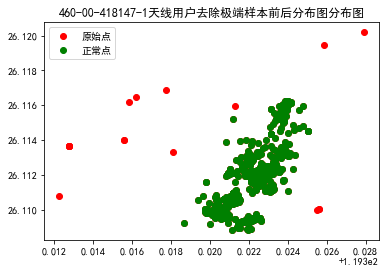

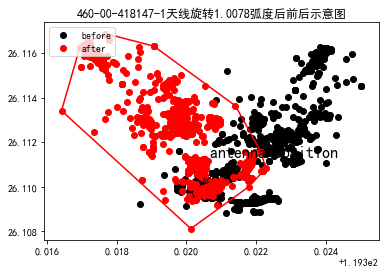

1


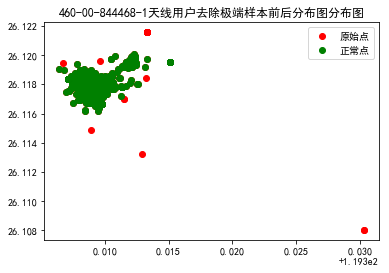

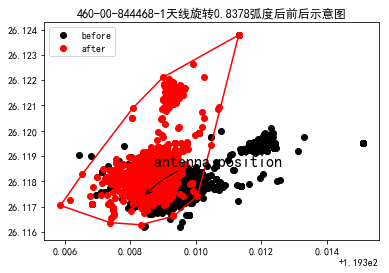

KeyboardInterrupt: 

In [155]:
df_selected_area_tuned = tools.estimate_rsrp_on_given_degrees(df_selected_area, df_selected_area_curr, df_affected_area, df_cell_info, lst_cells_to_tune, lst_degrees)

In [156]:
# 计算适应度函数值
# 确定评估区域中各栅格的弱覆盖率 设每个栅格弱覆盖用户占比达到0.005视为 弱覆盖栅格
b1 = df_selected_area.groupby(['grid_num']).weak_flag.mean()
b2 = len(b1[b1 > 0.0005])

df_selected_area_tuned['weak_flag'] =  df_selected_area_tuned['s_rsrp'].apply(lambda x: 1 if x < -120 else 0)
c1 = df_selected_area_tuned.groupby(['grid_num']).weak_flag.mean()
c2 = len(c1[c1 > 0.0005])
# df_final['weak_flag_tuned'] = df_final['s_rsrp_es'].apply(lambda x: 1 if x <
#                                                          -120 else 0)

# c1 = df_final.groupby(['grid_num']).weak_flag_tuned.mean()
# #    c2 = - c1.sum()  # c1.sum()越小越好 则 -c1.sum()越大越好
# c2 = len(c1[c1 > 0.005])
# print("调整前弱覆盖栅格个数：{} \n \b调整后弱覆盖栅格个数：{}".format(b2, c2))

In [152]:
c1.mean() - (c2 - b2)

0.00033023848218911265

In [149]:
c1.mean()

0.00033023848218911265

In [145]:
df_selected_area_tuned.shape

(7944500, 7)

In [132]:
df_selected_area.shape

(6070629, 6)